In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)#device_count={'GPU':1}
)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Masking, Embedding
from keras.models import Model
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences

import math
import os
import csv
from os import listdir
os.environ["CUDA_VISIBLE_DIVICES"]=''

# set random seed
seed(10)
tf.random.set_seed(10)

[1407, 4972, 2111, 2798, 3218, 500, 6182, 1116, 1079, 986, 1064, 2404, 3251, 5031, 3225, 3344, 3205, 3979, 4313, 3907, 3956, 6492, 3491, 3204, 8715, 3377, 4477, 3152, 2368, 3847, 3708, 4919, 3827, 3727, 1497, 3476, 2717, 3454, 3750, 2697, 851, 3686, 3191, 5352, 1380, 2300, 3474, 2724, 2964, 3532, 3141, 4790, 3881, 3974, 4595]
[500, 851, 986, 1064, 1079, 1116, 1380, 1407, 1497, 2111, 2300, 2368, 2404, 2697, 2717, 2724, 2798, 2964, 3141, 3152, 3191, 3204, 3205, 3218, 3225, 3251, 3344, 3377, 3454, 3474, 3476, 3491, 3532, 3686, 3708, 3727, 3750, 3827, 3847, 3881, 3907, 3956, 3974, 3979, 4313, 4477, 4595, 4790, 4919, 4972, 5031, 5352, 6182, 6492, 8715]


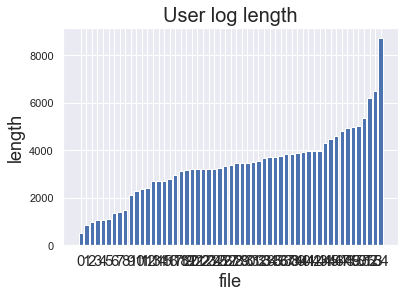

[[[0.56212699 0.77853316]
  [0.56250525 0.77734883]
  [0.56275076 0.77566991]
  ...
  [0.17725459 0.17735775]
  [0.17878243 0.17771565]
  [0.17998655 0.17811537]]

 [[0.06217145 0.01526194]
  [0.06187603 0.01568926]
  [0.06158928 0.01619516]
  ...
  [0.90433866 0.60650277]
  [0.90390057 0.60570229]
  [0.90339145 0.60481951]]

 [[0.06671002 0.01100964]
  [0.06652521 0.01166505]
  [0.06643671 0.01239972]
  ...
  [0.84696916 0.56423026]
  [0.8459497  0.56377258]
  [0.84484606 0.56327194]]

 ...

 [[0.60835409 0.78063051]
  [0.60869958 0.78115104]
  [0.60920595 0.78161753]
  ...
  [0.69576466 0.44988431]
  [0.69497081 0.44913997]
  [0.69420181 0.4483452 ]]

 [[0.03809905 0.11438292]
  [0.03778963 0.11538551]
  [0.03752254 0.11633642]
  ...
  [0.74103299 0.6636069 ]
  [0.74128542 0.66442429]
  [0.74150339 0.6653969 ]]

 [[0.98328788 0.90362   ]
  [0.98295443 0.90378679]
  [0.98258283 0.90398083]
  ...
  [0.17690286 0.34415288]
  [0.17786224 0.34573732]
  [0.17905475 0.34688556]]]


In [2]:
## 사용자의 log 분석
scaler = MinMaxScaler()

original_df = [] # 기존의 data
scaled_df = [] # 정규화된 data

# 모든 사용자 load
users = ['0mnEB226qqgHE79KLEfxRj6fiEK2']

for user in users:
    #print(user)
    original_list = []
    scaled_list = []
    len_list = []

    # log_info/user 폴더 하위에 있는 모든 파일에 대해 (즉, 모든 log파일에 대해) 도로 세그먼트 정보를 생성
    for file in listdir('./log_segment_info/'+user):
        log_name = file.split("_")[0]

        # log{logname}_info.csv 파일을 load
        log_csv_name= './log_segment_info/'+user+"/"+file
        if('segment' not in file):
            continue
            
        #print(log_csv_name)
        if os.path.isfile(log_csv_name):
            csv = pd.read_csv(log_csv_name, usecols=['mercX', 'mercY'])
            if len(csv) == 0:
                print("log length is 0")
                continue
                
            # segment matching이 실패한 행 제외
            #csv = csv[csv['seg_id'].notnull()]
            
            # 정규화
            scaled_csv = scaler.fit_transform(csv)
            
            original_list.append(csv.values.tolist())
            scaled_list.append(scaled_csv)
            len_list.append(len(csv))
        else:
            print("no log info")

    print(len_list)
    

    # 분포 그리기
    sorted_list = sorted(len_list)
    print(sorted_list)
    
    label = np.arange(len(sorted_list))
    index = np.arange(len(sorted_list))
    plt.bar(index, sorted_list)
    plt.title('User log length', fontsize=20)
    plt.xlabel('file', fontsize=18)
    plt.ylabel('length', fontsize=18)
    plt.xticks(index, label, fontsize=15)
    plt.show()

    # 최대 길이 선택
    selected_length = 6492

    # padding 추가 (pad_sequences)
    #original_df = pad_sequences(original_list, padding='post', maxlen=selected_length, dtype='float64')
    #scaled_df = pad_sequences(scaled_list, padding='post', maxlen=selected_length, dtype='float64')
    #print(scaled_df.shape)
    #print(scaled_df)
    
    # padding 추가 (경로 이어붙이기)
    for i in reversed(range(len(scaled_list))):
        padded_df = []
        
        current_df = scaled_list[i].tolist()
        current_len = len(current_df)
        num_repeat = math.ceil(selected_length / current_len)
        
        for j in range(num_repeat):
            padded_df = padded_df + current_df
            current_df = np.flip(current_df).tolist()
            
        padded_df = padded_df[0:selected_length]
        scaled_df.append(padded_df)
    scaled_df = np.array(scaled_df)
    print(scaled_df)

In [3]:
## 파일 불러오기 (단일 파일용)
'''
dir = 'C:/Users/HYS/Desktop/prev_src/log_segment_info/0mnEB226qqgHE79KLEfxRj6fiEK2'
#df = pd.read_csv(dir + '/log636556604_segment_info.csv', usecols=['latitude', 'longitude', 'seg_lat1', 'seg_long1', 'seg_lat2', 'seg_long2']) 
#df = df[df['seg_lat1'] != 0].reset_index(drop=True)
df = pd.read_csv(dir + '/log636556604_segment_info.csv', usecols=['latitude', 'longitude'])

df_list = []
df_list.append(df.values.tolist())
print(df_list)
padded_df = pad_sequences(df_list, padding='post', maxlen=selected_length, dtype='float64')
print(padded_df)
'''

"\ndir = 'C:/Users/HYS/Desktop/prev_src/log_segment_info/0mnEB226qqgHE79KLEfxRj6fiEK2'\n#df = pd.read_csv(dir + '/log636556604_segment_info.csv', usecols=['latitude', 'longitude', 'seg_lat1', 'seg_long1', 'seg_lat2', 'seg_long2']) \n#df = df[df['seg_lat1'] != 0].reset_index(drop=True)\ndf = pd.read_csv(dir + '/log636556604_segment_info.csv', usecols=['latitude', 'longitude'])\n\ndf_list = []\ndf_list.append(df.values.tolist())\nprint(df_list)\npadded_df = pad_sequences(df_list, padding='post', maxlen=selected_length, dtype='float64')\nprint(padded_df)\n"

In [4]:
## 정규화 (단일 파일용)
'''
#scaler = MinMaxScaler()
#scaled_df = scaler.fit_transform(df)
#print(scaled_df)
#print(len(scaled_df))
scaled_df = df.to_numpy()
'''

'\n#scaler = MinMaxScaler()\n#scaled_df = scaler.fit_transform(df)\n#print(scaled_df)\n#print(len(scaled_df))\nscaled_df = df.to_numpy()\n'

In [5]:
## LSTM에 입력하기 위해 reshape [samples(= batch 크기), timesteps(= time의 크기), features(= input 열의 개수)]

'''
# 데이터 window_size로 나누기
def temporalize(X, window_size):
    output_X = []
    for i in range(window_size - 1, len(X)):
        t = []
        for j in range(i - window_size+1, i+1):
            t.append(X[[j], :])
        output_X.append(t)
    return output_X

window_size = 3
X_train = temporalize(scaled_df, window_size)
X_train = np.array(X_train)

# reshape
X_train = X_train.reshape(X_train.shape[0], window_size, df.shape[1])
print(X_train)
print(len(X_train))
'''

'\n# 데이터 window_size로 나누기\ndef temporalize(X, window_size):\n    output_X = []\n    for i in range(window_size - 1, len(X)):\n        t = []\n        for j in range(i - window_size+1, i+1):\n            t.append(X[[j], :])\n        output_X.append(t)\n    return output_X\n\nwindow_size = 3\nX_train = temporalize(scaled_df, window_size)\nX_train = np.array(X_train)\n\n# reshape\nX_train = X_train.reshape(X_train.shape[0], window_size, df.shape[1])\nprint(X_train)\nprint(len(X_train))\n'

In [6]:
# #Autoencoder network model 정의
# return_sequences=True: decoder의 input에 encoder의 모든 output이 각각 사용됨
# RepeadVector: decoder의 input에 encoder의 제일 마지막 output만 사용됨

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    #masked = Masking(mask_value=0.)(inputs)
    encoder_1 = LSTM(64, activation='relu', return_sequences=False)(inputs)
    encoded_feature = RepeatVector(X.shape[1])(encoder_1)
    decoder_1 = LSTM(64, activation='relu', return_sequences=True)(encoded_feature)
    output = TimeDistributed(Dense(X.shape[2]))(decoder_1)
    model = Model(inputs=inputs, outputs=output)
    return model

In [7]:
# 학습
X_train = scaled_df
print(X_train.shape)
 
model = autoencoder_model(X_train)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['acc'])
model.summary()

(55, 6492, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6492, 2)]         0         
                                                                 
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 repeat_vector (RepeatVector  (None, 6492, 64)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 6492, 64)          33024     
                                                                 
 time_distributed (TimeDistr  (None, 6492, 2)          130       
 ibuted)                                                         
                                                                 
Total params: 50,306
Trainable params: 50,306
N

In [8]:
## n회 반복
nb_epochs = 50
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

Epoch 1/50
6/6 [==============================] - 206s 35s/step - loss: 0.3506 - acc: 0.4616 - val_loss: 0.3022 - val_acc: 0.3620
Epoch 2/50
6/6 [==============================] - 205s 33s/step - loss: 0.2665 - acc: 0.4616 - val_loss: 0.2140 - val_acc: 0.3620
Epoch 3/50
6/6 [==============================] - 199s 33s/step - loss: 0.1860 - acc: 0.4616 - val_loss: 0.1253 - val_acc: 0.3620
Epoch 4/50
6/6 [==============================] - 198s 33s/step - loss: 0.1464 - acc: 0.4614 - val_loss: 0.1410 - val_acc: 0.6072
Epoch 5/50
6/6 [==============================] - 196s 33s/step - loss: 0.1447 - acc: 0.5356 - val_loss: 0.1293 - val_acc: 0.6380
Epoch 6/50
6/6 [==============================] - 203s 34s/step - loss: 0.1308 - acc: 0.5384 - val_loss: 0.1070 - val_acc: 0.6380
Epoch 7/50
6/6 [==============================] - 183s 31s/step - loss: 0.1256 - acc: 0.5391 - val_loss: 0.1033 - val_acc: 0.6072
Epoch 8/50
6/6 [==============================] - 185s 30s/step - loss: 0.1182 - acc: 0.53

In [9]:
## 모델의 예측값 확인
print(X_train.shape)
yhat = model.predict(scaled_df, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X_train, 3))

## 모델 평가하기
loss_and_metrics = model.evaluate(X_train, X_train, batch_size=batch_size)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

(55, 6492, 2)
---Predicted---
[[[0.111 0.109]
  [0.173 0.167]
  [0.223 0.216]
  ...
  [0.478 0.503]
  [0.478 0.503]
  [0.478 0.503]]

 [[0.119 0.126]
  [0.187 0.196]
  [0.244 0.252]
  ...
  [0.523 0.545]
  [0.523 0.545]
  [0.523 0.545]]

 [[0.117 0.123]
  [0.184 0.191]
  [0.24  0.247]
  ...
  [0.514 0.536]
  [0.514 0.536]
  [0.514 0.536]]

 ...

 [[0.116 0.119]
  [0.181 0.184]
  [0.236 0.237]
  ...
  [0.506 0.528]
  [0.506 0.528]
  [0.506 0.528]]

 [[0.115 0.122]
  [0.181 0.189]
  [0.236 0.243]
  ...
  [0.503 0.523]
  [0.503 0.523]
  [0.503 0.523]]

 [[0.112 0.11 ]
  [0.174 0.168]
  [0.225 0.217]
  ...
  [0.48  0.495]
  [0.48  0.495]
  [0.48  0.495]]]
---Actual---
[[[0.562 0.779]
  [0.563 0.777]
  [0.563 0.776]
  ...
  [0.177 0.177]
  [0.179 0.178]
  [0.18  0.178]]

 [[0.062 0.015]
  [0.062 0.016]
  [0.062 0.016]
  ...
  [0.904 0.607]
  [0.904 0.606]
  [0.903 0.605]]

 [[0.067 0.011]
  [0.067 0.012]
  [0.066 0.012]
  ...
  [0.847 0.564]
  [0.846 0.564]
  [0.845 0.563]]

 ...

 [[0.608 

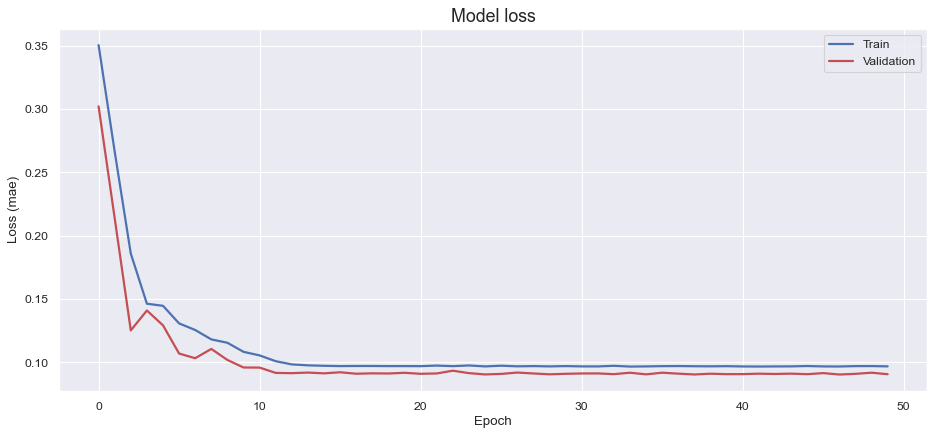

In [10]:
## Training accuracy 그리기
#fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
#ax.plot(history['acc'], 'b', label='Train', linewidth=2)
#ax.plot(history['val_acc'], 'r', label='Validation', linewidth=2)
#ax.set_title('Model accuracy', fontsize=16)
#ax.set_ylabel('Accuracy')
#ax.set_ylabel('Epoch')
#ax.legend(loc='upper right')
#plt.show()

## Training loss 그리기
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [11]:
def restore(X, window_size):
    output_X = []
    for i in range(0, len(X)):
        output_X.append(X[i, 0])
        if (i == len(X) - 1):
            for j in range(1, window_size):
                output_X.append(X[i, j])
    return np.array(output_X)

# Training set의 loss 분포 그리기
X_pred = model.predict(X_train)
X_pred = restore(X_pred, window_size)
X_pred = pd.DataFrame(X_pred, columns=df.columns)
X_pred.index = df.index

scored = pd.DataFrame(index=df.index)
Xtrain = restore(X_train, window_size)
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)
plt.figure(figsize=(16, 9), dpi=80)
plt.title('Loss Disttribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue')
plt.xlim([0.0, 0.03])

NameError: name 'window_size' is not defined

In [ ]:
# test set에서 reconstruction loss 계산
print('anomaly threshold = {}'.format(np.percentile(scored, 100)))
threshold = np.percentile(scored, 100)

#X_pred = model.predict(X_test)
#X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
#X_pred = pd.DataFrame(X_pred, columns=test.columns)
#X_pred.index = test.index

#scored = pd.DataFrame(index=test.index)
#Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
#scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis=1)
#scored['Threshold'] = threshold
#scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
#scored[scored['Anomaly']==1]